#  Convolutional NN it for facial keypoints recognition

Here I will build a convolutional neural network, and train it for the task of facial keypoints recognition. The data are obtained from a Kaggle competition https://www.kaggle.com/c/facial-keypoints-detection/overview. For a preview loook at the dataset see the notebook facial_keypoints_intro.ipynb.

The CNN is built using tensorflow. 

##  Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from sklearn.model_selection import train_test_split
import tensorflow as tf

%matplotlib inline

##  Loading data

In [2]:
# Reading source data.
training_data = pd.read_csv('training.csv')

In [3]:
#Images are stored as string. We convert them to a np array. 

images = training_data['Image'].apply(lambda str_pic: np.array([int(px) for px in str_pic.split()]))
images = np.vstack([images.iloc[i] for i in range(len(images))])

In [4]:
#Creating keypoints dataframe. 
keypoints = training_data.drop('Image', axis = 1)

## Data augmentation: Including reflected pictures into the dataset

In order to increase our dataset I will reflect all images left to right, and add them as different images.

This implies flipping the images, and reflecting all x-coordinates of the keypoints such that $x_{reflected} = 95 - x_{old}$.


In [5]:
# Building an array of reflected images.
# The images are given as a flat list. We could reshape them and use np.flip, 
# or grab portions of 96 elements each and flip those. 
# we take the second option. The result is a flat version of the reflected image. 
flipped_ims = np.zeros(images.shape)
for j in range(images.shape[0]):
    for i in range(96):
        flipped_ims[j,i*96:(i+1)*96] = np.flip(images[j,i*96:(i+1)*96])

In [6]:
# Adding the reflected images to the images array. 
# RUN THIS CELL ONLY ONCE. 
images = np.vstack((images, flipped_ims))

In [7]:
# Now the keypoints. I need to switch left and right features, 
# and reflect the x coordinates by x --> 95-x (95 is the last coordinate of the picture. )

reflected_keypoints = pd.DataFrame(columns = keypoints.columns)

# We look for the correspoding columns by switching 'left' <--> 'right'.
for colname in reflected_keypoints.columns:
    if 'left' in colname:
        reference_col = colname.replace('left', 'right')
    elif 'right' in colname:
        reference_col = colname.replace('right','left')
    else:
        reference_col = colname
        
    # Assigning values and reflecting x coordinates
    # reflected_keypoints[colname] = keypoints[reference_col].apply(lambda x: 95-x if colname[-1]=='x' else x)
    # the one-line version is fine but I think separating is more readable.
    
    reflected_keypoints[colname] = keypoints[reference_col]
    if colname[-1] == 'x':
        reflected_keypoints[colname] = reflected_keypoints[colname].apply(lambda x: 95-x)   

In [8]:
# Adding reflected keypoints to the original keypoints. 
# RUN THIS CELL ONLY ONCE.
keypoints = pd.concat([keypoints,reflected_keypoints], ignore_index=True)

## Perform a train_test_split in order to have a cross validation set. 

In [9]:
x_train, x_cv, keypoints_train, keypoints_cv = train_test_split(images, keypoints, 
                                                                test_size=0.1, random_state = 42)

# We have around 14000 examples, so taking 10% for the validation set would mean about 1400 examples. 

# 100 is a rather small size for a validation, less than 1%, but in this case it is a mere guidance. 

In [10]:
# BASELINE
# As a guide, we compute the error on the cv set obtained by using the mean position of
# each keypoint.

mean_keypoints = keypoints_train.mean()
baseline_rmse = np.sqrt(((keypoints_cv - mean_keypoints)**2).mean().mean())

print('Using the mean poistion the RMSE on the cv set is: ', baseline_rmse)

Using the mean poistion the RMSE on the cv set is:  3.741829318666387


A good estimation should improve on this result. 

##  Define a function for taking random batches. 

In [11]:
def next_batch(X, labels, batch_size):
    """ A function for generating training batches. 
    X = Collection of examples.
    labels = True labels. 
    batch_size = Number of elements to be randomly selected. """
    sample_indices = np.random.choice(range(len(X)), size = batch_size, 
                                      replace = False)
    
    images = X[sample_indices]
    keypoints = labels.iloc[sample_indices]
        
    return images, keypoints

# Building the CNN

I will start by using the same architechture I used in the course.For the moment I will use train_test_split to test my network a bit. Eventually this wont be necessary, as the dataset provides a separate test set. 

In [12]:
# Wrappers of tensorflow methods. This functions will help make
# the construction of the network more straightforward. 

def init_weights(shape):
    init_random_dist = tf.initializers.random_normal(stddev=0.1)
    #init_random_dist = tf.initializers.he_normal()
    return tf.get_variable('weights', shape=shape ,initializer= init_random_dist)

def init_bias(shape):
    #init_bias_vals = tf.random_uniform(shape=shape)
    init_bias_vals = tf.initializers.random_uniform()
    return tf.get_variable('bias', shape = shape ,initializer= init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

   
# For eventually including batch normalization. 
def new_bn_layer(input_x, training, decay = 0.999):
    """ Wrapper function for tf.contrib.layers.batch_norm """
    
    return tf.contrib.layers.batch_norm(input_x, decay = decay, is_training = training  )

# Building the network

In [13]:
tf.reset_default_graph()

In [14]:
# PLACEHOLDERS

x = tf.placeholder(tf.float32, [None, 9216], name = 'images')
keypoints_true = tf.placeholder(tf.float32, [None, 30], name = 'true_keypoints')
lr = tf.placeholder(tf.float32, name = 'learning_rate')
drop_rate = tf.placeholder(tf.float32, name = 'dropout_prob')

#training = tf.placeholder(tf.bool, name='training_state')

with tf.variable_scope('parameter_logs'):
    parameter_log_ph = tf.placeholder(tf.string,[None,2], name='ph')
    parameter_log = tf.summary.text('summary_node', parameter_log_ph)


In [15]:
# Normalize each image before feeding it as input. 
x_images = tf.image.per_image_standardization(tf.reshape(x, [-1,96,96,1]))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [16]:
# LAYERS

with tf.variable_scope('Convo1'):
    convo1 = convolutional_layer(x_images, [6,6,1,32]) # 6 x 6 filter, 1 channel in, 32 channels out. SAME padding.
                                            # so output images are also 96 x 96. 

    convo1_pool = tf.nn.max_pool(convo1, ksize=[1, 4, 4, 1],
                          strides=[1, 4, 4, 1], padding='SAME')   #output of 24 x 24 x 32
        
with tf.variable_scope('Convo2'):    
    convo2 = convolutional_layer(convo1_pool, [2,2,32,64]) # 2x2 filter, 64 outputs. SAME padding.

    convo2_pool = max_pool_2by2(convo2) # 2x2 max pooling, output 12 x 12 x64
    
            
with tf.variable_scope('Convo3'):
    convo3 = convolutional_layer(convo2_pool, [2,2,64,128]) # 2x2 filter, 128 outputs. SAME padding.

    convo3_pool = max_pool_2by2(convo3) # 2x2 max pooling, output 6x6 x 128

    convo3_flat = tf.reshape(convo3_pool,[-1,6*6*128])
    
with tf.variable_scope('Full_one'):
    
    full_layer_one = tf.nn.relu(normal_full_layer(convo3_flat,1024))
    
        
# DROPOUT 

full_one_dropout = tf.nn.dropout(full_layer_one, rate = drop_rate)

# OUTPUT LAYER
with tf.variable_scope('Output'):
    
    keypoints_pred = normal_full_layer(full_one_dropout,30)
    

In [17]:
# LOSS FUNCTION
# The loss functions needs to take into account that not all keypoints have values in our trianing 
# data. These keypoints need to be excluded from the computation of the loss function in 
# order to prevent it from giving NaN.

with tf.variable_scope('Loss'):
    masked_loss = tf.reduce_mean(tf.square(
        tf.boolean_mask(keypoints_pred - keypoints_true, tf.is_finite(keypoints_true) ) ) ) 
    
    MSE_summary = tf.summary.scalar('MSE', masked_loss)

# The next lines are for updating the moving averages when using batch normalization, 
# as specified in the documentation for tf.contrib.layers.batch_norm. Without batch_norm they
# are harmless. 
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
        
    optimizer = tf.train.AdamOptimizer(learning_rate=lr)

    train = optimizer.minimize(masked_loss)

Instructions for updating:
Use tf.cast instead.


/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [18]:
# INITIALIZER

init = tf.global_variables_initializer()

saver = tf.train.Saver()

In [56]:
# Keep track of models and runs. 

model_number = 1
run_number = 1 # Used for labeling different training runs. It is updated after training. 

## Training

Currently on step 5000
Train MSE:  1.6344249
Train RMSE:  1.2784463 

CV MSE: 5.297542
CV MSE: 2.301639 

Parameters: 
[['model_number' '1']
 ['run_number' '2']
 ['training_size' '12688']
 ['cv_size' '1410']
 ['steps' '5000']
 ['batch_size' '32']
 ['learning_rate' '0.0005']
 ['drop_rate' '0.2']]


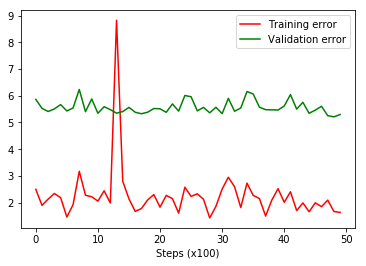

In [62]:
num_steps = 5000
batch_size = 32
learning_rate = 0.0005
drop = 0.2


# Recording parameters. Also including the sizes of the training and validation sets,  
# the run number and model number. 
params_values = np.array([['model_number', model_number],
                          ['run_number', run_number], 
                          ['training_size', len(x_train)  ], 
                          ['cv_size', len(x_cv)], 
                          ['steps', num_steps],
                          ['batch_size', batch_size], 
                          ['learning_rate', learning_rate ], 
                          ['drop_rate', drop]])

#setting up directories for model and summaries. 

model_dir = './model_' + str(model_number)
log_dir = model_dir + '/logs/run' + str(run_number)

#Setting up figure for plotting losses as training advances. 
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

with tf.Session() as sess:
        
    train_writer = tf.summary.FileWriter(log_dir + '/train/', sess.graph) #only need the graph once. 
    cv_writer = tf.summary.FileWriter(log_dir +'/cv/')
    
    
    #initialize variables if first run or load saved model. 
    if run_number == 1:
        sess.run(init) 
    else:
        saver.restore(sess, model_dir + '/keypoints_cnn' )  
    
    # Python lists to keep track of errors on the notebook. 
    train_losses = []
    cv_losses = []
    
    # Record hyperparameters.
    
    train_writer.add_summary(sess.run(parameter_log, feed_dict = {parameter_log_ph:params_values }))
    
    # Training loop
    for iteration in range(num_steps+1):
        
        # Get random batch. 
        x_batch, keypoints_batch = next_batch(x_train, keypoints_train, batch_size)
        
        
        sess.run(train, feed_dict={x: x_batch, 
                                   keypoints_true: keypoints_batch, lr:learning_rate, drop_rate:drop})
        
        # Print short report each 100 iterations. 
        if iteration%100 == 0:
            
            train_loss, train_summ = sess.run([masked_loss, MSE_summary], 
                                              feed_dict={x: x_batch, keypoints_true: keypoints_batch,
                                                        drop_rate:0}) #Compute the training error without dropout. 
            
            cv_loss, cv_summ = sess.run([masked_loss, MSE_summary],
                               feed_dict={x:x_cv, keypoints_true:keypoints_cv, drop_rate:0})
            
            # Writting summaries for tensorboard. 
            train_writer.add_summary(train_summ, iteration)
            cv_writer.add_summary(cv_summ, iteration)
            
            # Upadte Python lists with errors. 
            train_losses.append(train_loss)
            cv_losses.append(cv_loss)
                                    
            # Showing output for tracking progress as training evolves.
            print('=======================================')
            print('Currently on step {}'.format(iteration))
            print('Train MSE: ', train_loss)
            print('Train RMSE: ', np.sqrt(train_loss), '\n')
            print('CV MSE:', cv_loss)
            print('CV RMSE:', np.sqrt(cv_loss), '\n')
            
            ax.cla()
            ax.plot(train_losses[-50:], 'r', label = 'Training error')
            ax.plot(cv_losses[-50:], 'g', label = 'Validation error')
            ax.legend()
            ax.set_xlabel('Steps (x100)')
            display(fig)
            
            print('=======================================')
            #print('train_losses = ', train_losses, '\n')
            #print('cv_losses = ', cv_losses)
            
            clear_output(wait = True)
    
    # Printing final short report.
    
    print('=======================================')
    print('Currently on step {}'.format(iteration))
    print('Train MSE: ', train_losses[-1])
    print('Train RMSE: ', np.sqrt(train_losses[-1]), '\n')
    print('CV MSE:',  cv_losses[-1])
    print('CV MSE:',  np.sqrt(cv_losses[-1]), '\n')
    print('Parameters: ')
    print(params_values)

    ax.cla()
    ax.plot(train_losses[1:], 'r', label = 'Training error')
    ax.plot(cv_losses[1:], 'g', label = 'Validation error')
    ax.legend()
    ax.set_xlabel('Steps (x100)')
    
            
    print('=======================================')
    #print('train_losses = ', train_losses, '\n')
    #print('cv_losses = ', cv_losses)
            
    # Saving model
    saver.save(sess, model_dir + '/keypoints_cnn' )
    
    train_writer.close()
    cv_writer.close()
    
    run_number +=1

## Predictions for the cv set

In [74]:
with tf.Session() as sess:
    
    # Loading the saved model. 
    saver.restore(sess, model_dir + '/keypoints_cnn' )

    # Forward propagation to generate the predictions, and computing the loss.     
    predictions, loss = sess.run([keypoints_pred, masked_loss], feed_dict= {x:x_cv, keypoints_true:keypoints_cv, 
                                                                          drop_rate:0 })
    

INFO:tensorflow:Restoring parameters from ./model_1/keypoints_cnn


In [75]:
print('MSE', loss)
print('RMSE', np.sqrt(loss))

MSE 5.297542
RMSE 2.301639


In [76]:
# Sanity check:
# Find if there are any points out of bounds (hihgher than 96 or below 0).

np.where((predictions >= 96) | (predictions < 0))

(array([], dtype=int64), array([], dtype=int64))

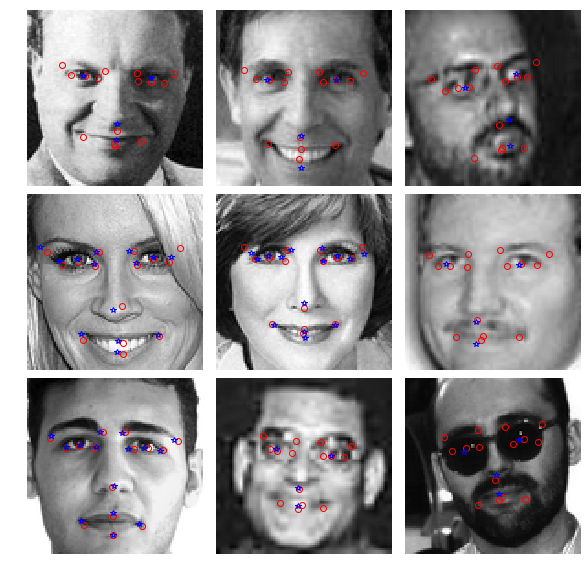

In [77]:
# Visualizing some of the predicted points. 

grid_size = 3
fig, axes = plt.subplots(grid_size, grid_size, gridspec_kw = dict(hspace = .05, wspace = .05), 
                         figsize=(10,10))

selection = np.random.choice(range(len(x_cv)), size = grid_size**2, )

mean_x_points = [mean_keypoints[j] for j in range(0,30,2)]
mean_y_points = [mean_keypoints[j+1] for j in range(0,30,2)]

for i, ax in zip(selection, axes.flat):

    ax.axis('off')
    # Plotting the faces
    ax.imshow(x_cv[i].reshape((96,96)),cmap='gist_gray')

 # Obtaining  predicted keypoints positions. 
 # x and y coordinates correspond to even or odd indices, respectively. 
    x_points = [predictions[i][j] for j in range(0,30,2)]
    y_points = [predictions[i][j+1] for j in range(0,30,2)]
      
    # Plotting predicted keypoints
    ax.plot(x_points, y_points, 'ro', markerfacecolor = 'none')    
  
 # Plotting true keypoints
    
    x_true = [keypoints_cv.iloc[i][j] for j in range(0,30,2)]
    y_true = [keypoints_cv.iloc[i][j+1] for j in range(0,30,2)]
    
    ax.plot(x_true, y_true, 'b*', markerfacecolor = 'none')    
    
 # Including mean keypoints
       
    #ax.plot(mean_x_points, mean_y_points, 'b+', markerfacecolor = 'none')  

## Predictions for the test set

In [51]:
# loadingn test images. 
test_data = pd.read_csv('test.csv')
test_data.shape

(1783, 2)

In [52]:
# View test df.
test_data.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [33]:
# Converting string images to array.
test_images = test_data['Image'].apply(lambda str_pic: np.array([int(px) for px in str_pic.split()]))

test_images = np.vstack([test_images.iloc[i] for i in range(len(test_images))])

In [34]:
saver = tf.train.Saver()

In [65]:
with tf.Session() as sess:
    
    # Load model.
    saver.restore(sess, model_dir + '/keypoints_cnn' )
    
    # Forward prop to generate the predictions.     
    predictions = sess.run(keypoints_pred, feed_dict= {x:test_images, drop_rate:0 })
    

INFO:tensorflow:Restoring parameters from ./model_1/keypoints_cnn


In [36]:
predictions.shape

(1783, 30)

In [66]:
# Sanity check:
# Find if there are any points out of bounds (hihgher than 96 or below 0).

np.where((predictions >= 96) | (predictions < 0))

(array([], dtype=int64), array([], dtype=int64))

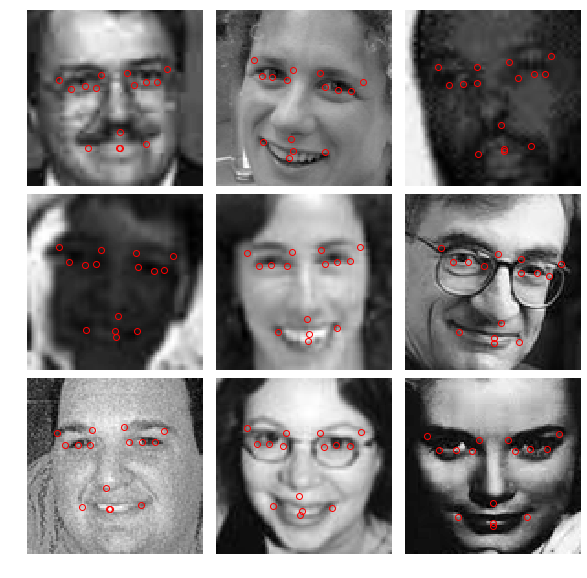

In [69]:
# Visualize test images and predictions. 

grid_size = 3
fig, axes = plt.subplots(grid_size, grid_size, gridspec_kw = dict(hspace = .05, wspace = .05), 
                         figsize=(10,10))

selection = np.random.choice(range(len(test_images)), size = grid_size**2 )
#selection = [0, 563, 491, 927]
for i, ax in zip(selection, axes.flat):

    ax.axis('off')
    # Plotting the faces
    ax.imshow(test_images[i].reshape((96,96)),cmap='gist_gray')

 # Obtaining keypoints positions. x and y coordinates are even and odd indices respectively. 
    x_points = [predictions[i][j] for j in range(0,30,2)]
    y_points = [predictions[i][j+1] for j in range(0,30,2)]
      
    #plotting predicted keypoints
    ax.plot(x_points, y_points, 'ro', markerfacecolor = 'none')    

## Make a dataframe with predictions

In [41]:
predicted_keypoints = pd.DataFrame(data = predictions, columns = keypoints.columns)

## Loading the lookup table to make a submission file. 

In [39]:
lookup_table = pd.read_csv('IdLookupTable.csv', header = 0, index_col = 'RowId')

In [70]:
# Find the requested keypoints. 
locations_list = []
for i in lookup_table.iterrows():
    position = predicted_keypoints.iloc[i[1]['ImageId']-1][i[1]['FeatureName']]
    locations_list.append(position)
len(locations_list)

27124

In [71]:
# Empty dataframe for storing submission
Submission_df = pd.DataFrame(columns = ['Location'], index = lookup_table.index)

In [72]:
# Write predicted positions. 
Submission_df['Location'] = locations_list

In [73]:
# Save submission to csv. 
Submission_df.to_csv(model_dir + '/submission_1.csv')